In [1]:
11+31+31+30+6

109

In [1]:
##importing necessary libraries for computation and analysis
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow.compat.v1 as tf
import xarray as xr
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import time

add_data = '/home/cccr/roxy/matin/MTech_project/data/'
save_path = "/home/cccr/roxy/matin/MTech_project/model/Conv-LSTM/"


In [2]:
dataset = xr.open_dataset( add_data + "sst40yearmean.nc")
ds = xr.open_dataset( add_data + "sst.day.mean.2021.nc")
ds_40=dataset.sel(time=~((dataset.time.dt.month == 2) & (dataset.time.dt.day == 29)))


## Calculating 90th percentile

In [3]:
nintey_percentile = ds_40.groupby('time.dayofyear').quantile(0.9,dim='time',skipna=True)
avg_data = ds_40.groupby('time.dayofyear').mean(dim='time',skipna=True)

## Detecting warm pool

In [14]:

# Open datasets
sst = xr.open_dataset(add_data + "MJJAS.nc")
sst40 = sst.sst.assign_coords({'time': sst.sst.time.dt.dayofyear})
sst40_time = sst40.time[27:]
sst1 = xr.open_dataset(add_data + "jjas40mean.nc")
da = xr.open_dataset(add_data + "Percentilejjas.nc")
Percentilejjas2 = xr.open_dataset(add_data + "Percentilejjas2.nc")


a = sst.sel(time=slice("2017-05-01","2017-09-30"))
a.sst[27:].assign_coords({'time':da.time[27:].dt.dayofyear})



# Initialize lists for storing data
frq_40_list = []
frq_40jjas_list = []
inten_40_list = []

a = sst.sel(time=slice("2017-05-01","2017-09-30"))
dataset = a.sst[27:].assign_coords({'time':da.time[27:].dt.dayofyear})

change1 = dataset - Percentilejjas2
change2 = change1.__xarray_dataarray_variable__.rename('sst')
change = change2.assign_coords({'time':da.time[27:].dt.dayofyear})

logic1 = xr.where(change > 0, 1, change)
logic2 = xr.where(logic1 < 0, 0, logic1)
logic = logic2.assign_coords({'time':da.time[27:].dt.dayofyear})

l = []
for j in range(0, 122):
    five_days_sum = logic[j:j + 5].sum('time', skipna=False)
    l.append(xr.where(five_days_sum < 5, 0, five_days_sum).data)
five_xr = xr.DataArray(np.array(l), coords=[("time", logic[4:].time.data), ("lat", logic[4:].lat.data), ("lon", logic[4:].lon.data)])

five_xr_logic = xr.where(five_xr == 5, 1, five_xr)

m = []
for k in range(0, 122):
    a = five_xr_logic[k:k + 2].sum("time", skipna=False)
    m.append(xr.where(a > 1, 0, a).data)
five_xr_start = xr.DataArray(np.array(m), coords=[("time", logic[4:].time.data), ("lat", logic[4:].lat.data), ("lon", logic[4:].lon.data)])
frq_40jjas_list.extend(five_xr_start.data)
frq_40_list.append(five_xr_start.sum("time", skipna=False).data)
inten_40_list.append(xr.where(five_xr_logic == 1, change[4:], five_xr_logic).sum("time", skipna=False).data)

# Create xarray DataArrays for frq_40, frq_40jjas, and inten_40
inten_17 = xr.DataArray(np.array(inten_40_list), coords=[("time", sst40_time[:1].data), ("lat", logic.lat.data), ("lon", logic.lon.data)])
cum_intensity_17mon = inten_17.sum("time", skipna=False)

frq_17mon = xr.DataArray(np.array(frq_40_list), coords=[("time", sst40_time[:1].data), ("lat", logic.lat.data), ("lon", logic.lon.data)])


## Cumulative Intensity 2017

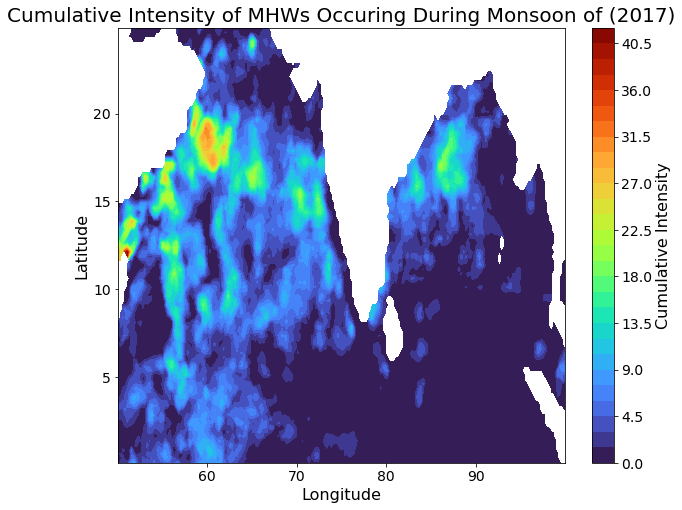

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))

cmap = plt.get_cmap('turbo')

contour_plot = ax.contourf(cum_intensity_17mon.lon, cum_intensity_17mon.lat, cum_intensity_17mon,
                           cmap=cmap, levels=30)

# Add a colorbar
cbar = plt.colorbar(contour_plot)
cbar.ax.set_ylabel('Cumulative Intensity', fontsize=16)
cbar.ax.tick_params(labelsize=14)

ax.set_title('Cumulative Intensity of MHWs Occuring During Monsoon of (2017)', fontsize=20)
ax.set_xlabel('Longitude', fontsize=16)
ax.set_ylabel('Latitude', fontsize=16)

ax.tick_params(labelsize=14)

plt.show()

fig.savefig('MHW2017_intens.png', bbox_inches='tight')


## Frequency of MHWs Occuring During Monsoon of (2017)

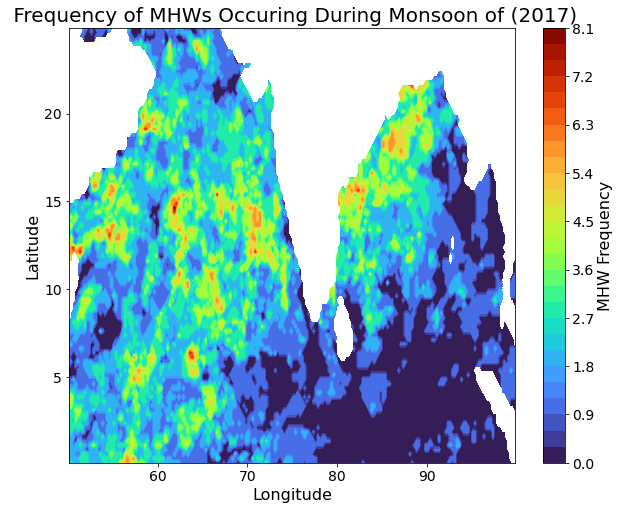

In [6]:
frq_40_sum = frq_17mon.sum("time",skipna=False)
frq_40_sum = xr.where(frq_40_sum%2==0,frq_40_sum//2,(frq_40_sum+1)/2)
fig, ax = plt.subplots(figsize=(10, 8))

cmap = plt.get_cmap('turbo')

contour_plot = ax.contourf(frq_40_sum.lon, frq_40_sum.lat, frq_40_sum,
                           cmap=cmap, levels=30)

# Add a colorbar
cbar = plt.colorbar(contour_plot)
cbar.ax.set_ylabel('MHW Frequency', fontsize=16)
cbar.ax.tick_params(labelsize=14)

ax.set_title(' Frequency of MHWs Occuring During Monsoon of (2017)', fontsize=20)
ax.set_xlabel('Longitude', fontsize=16)
ax.set_ylabel('Latitude', fontsize=16)

ax.tick_params(labelsize=14)
#fig.savefig('MHW40yr_Freq.png', bbox_inches='tight')
plt.show()


## Slicing the region of interest

In [16]:
ds_40 = ds_40.sst.sel(lon=slice(84,93.625),lat=slice(15,21.125))

## MHW @ BOB for Year 2017

In [17]:
roi = ds_40[-1825:-1460].sel(lon=slice(84,93.625),lat=slice(15,21.125))
sst_mean_roi = roi.astype(np.float32).mean(dim=['lat','lon']).data

rolling_mean = nintey_percentile.rename({'dayofyear':'time'}).rolling(time=11).mean()
rolling_avg = avg_data.rename({'dayofyear':'time'}).rolling(time=11).mean()
NinteyPercentile_spatmean = rolling_mean.sst.sel(lon=slice(89,94),lat=slice(14,19)).astype(np.float32).mean(dim=['lat','lon']).data[:-1]
Average_spatmean = rolling_avg.sst.sel(lon=slice(89,94),lat=slice(14,19)).astype(np.float32).mean(dim=['lat','lon']).data[:-1]
time = pd.date_range("2017-01-01", periods=365)


SST_mean_roi = pd.DataFrame(sst_mean_roi, index = time, columns=['SST'])
NinteyPercentile_spatmean = pd.DataFrame( NinteyPercentile_spatmean, index = time, columns=['90percentile'])
Average_spatmean = pd.DataFrame( Average_spatmean, index = time, columns=['Avg40'])

DataFrame = pd.concat([SST_mean_roi, NinteyPercentile_spatmean, Average_spatmean],axis=1)


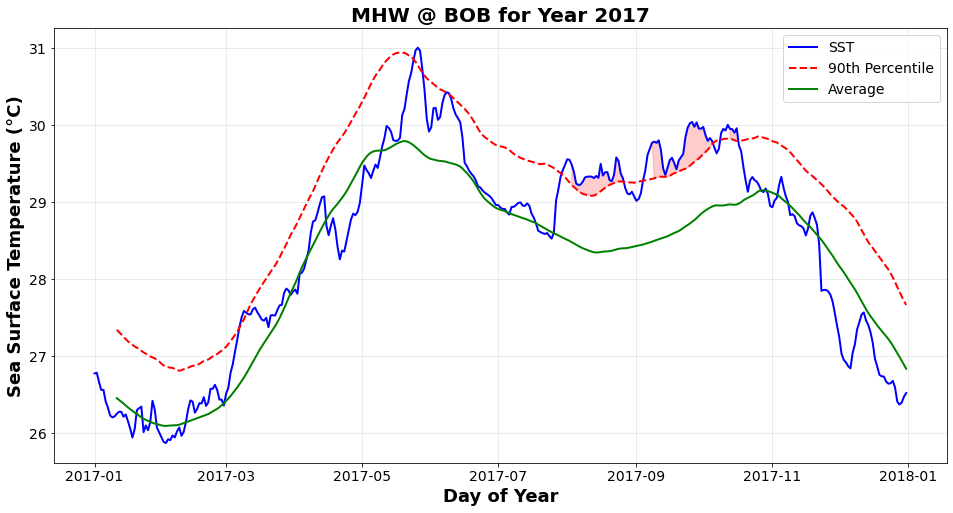

In [19]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(DataFrame['SST'], color='blue', linewidth=2, label='SST')

ax.plot(DataFrame['90percentile'], color='red', linestyle='--', linewidth=2, label='90th Percentile')

ax.plot(DataFrame['Avg40'], color='green', linewidth=2, label='Average')

mask = (DataFrame['SST'] > DataFrame['90percentile']).rolling(5).sum()>=5
ax.fill_between(DataFrame.index, DataFrame['SST'], DataFrame['90percentile'], where=mask, interpolate=True, color='red', alpha=0.2)

ax.set_xlabel("Day of Year", fontsize=18, fontweight='bold')
ax.set_ylabel("Sea Surface Temperature (°C)", fontsize=18, fontweight='bold')

ax.set_title("MHW @ BOB for Year 2017", fontsize=20, fontweight='bold')

ax.legend(loc="upper right", fontsize=14)

ax.tick_params(axis='both', labelsize=14)
ax.grid(alpha=0.3)

plt.show()
fig.savefig('MHW2017.png', bbox_inches='tight')



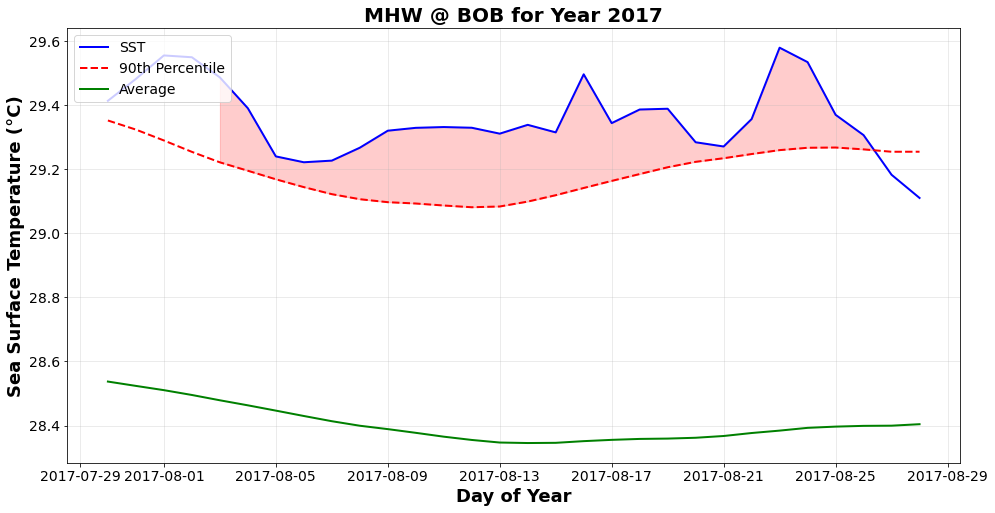

In [20]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(DataFrame['SST'][210:240], color='blue', linewidth=2, label='SST')

ax.plot(DataFrame['90percentile'][210:240], color='red', linestyle='--', linewidth=2, label='90th Percentile')

ax.plot(DataFrame['Avg40'][210:240], color='green', linewidth=2, label='Average')

mask = (DataFrame['SST'][210:240] > DataFrame['90percentile'][210:240]).rolling(5).sum()>=5
ax.fill_between(DataFrame.index[210:240], DataFrame['SST'][210:240], DataFrame['90percentile'][210:240], where=mask, interpolate=True, color='red', alpha=0.2)

ax.set_xlabel("Day of Year", fontsize=18, fontweight='bold')
ax.set_ylabel("Sea Surface Temperature (°C)", fontsize=18, fontweight='bold')

ax.set_title("MHW @ BOB for Year 2017", fontsize=20, fontweight='bold')

ax.legend(loc="upper left", fontsize=14)

ax.tick_params(axis='both', labelsize=14)
ax.grid(alpha=0.3)

plt.show()
fig.savefig('MHW2017mon.png', bbox_inches='tight')



In [21]:
import xarray as xr
import numpy as np
import pandas as pd
import scipy as sc
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import seaborn as sns

add_data = "/home/cccr/roxy/matin/MTech_project/data/"

def filter_signal_scipy(signal,sample_freq,ltime_period,htime_period,keep_mean):
    filter_signal=np.zeros(signal.shape)
    if any(np.isnan(signal)):
        raise ValueError('There is NaN in the signal')
    else:
        hf=1./ltime_period
        lf=1./htime_period

        temp_fft = sc.fftpack.fft(signal)

        fftfreq = np.fft.fftfreq(len(signal),sample_freq) ### daily data it is 1./365 ## monthly data 1./12 ## yearly data=1
          
        i1=(np.abs(fftfreq) >= lf) & (np.abs(fftfreq) <= hf)  
        inv_fft=np.zeros(temp_fft.size,dtype=complex)
        inv_fft[i1]=temp_fft[i1]
        if keep_mean:
            inv_fft[0]=temp_fft[0]
        filter_signal= np.real_if_close(sc.fftpack.ifft(inv_fft))
    
    return filter_signal

def norm_anom_var(var):
    mean_var = np.mean(var)
    anom_var = var - mean_var
    std_var = np.std(var)
    norm_anom_var = anom_var / std_var
    return norm_anom_var

rf = xr.open_dataarray(add_data + "rfbobmm_daily_1998-2019.nc")[:-30]
rf = rf.interpolate_na(dim="time")
sst = xr.open_dataarray(add_data + "tmpC_sstbob_1998-2020.nc")[:-731]

n_rf = rf
for i in range(0,39):
    for j in range(0,25):
        n_rf[:,j,i] = norm_anom_var(rf[:,j,i])
n_sst = sst        
for i in range(0,39):
    for j in range(0,25):
        n_sst[:,j,i] = norm_anom_var(sst[:,j,i])


sample_freq = 1
ltime_period = 30
htime_period = 60
keep_mean = 0

filtered_rf = n_rf
for i in range(0,39):
    for j in range(0,25):
        filtered_rf[:,j,i] = filter_signal_scipy(n_rf[:,j,i].values, sample_freq,
                                              ltime_period, htime_period, keep_mean)
filtered_sst = n_sst
for i in range(0,39):
    for j in range(0,25):
        if any(np.isnan(n_sst[:,j,i].values)):
            pass
        else:
            filtered_sst[:,j,i] = filter_signal_scipy(n_sst[:,j,i].values, sample_freq,
                                              ltime_period, htime_period, keep_mean)

In [22]:
rf = xr.open_dataarray(add_data + "rfbobmm_daily_1998-2019.nc")[:-30]
rf = rf.interpolate_na(dim="time")
sst = xr.open_dataarray(add_data + "tmpC_sstbob_1998-2020.nc")[:-731]

sst_mon = sst.isel(time=sst.time.dt.month.isin([5, 6, 7, 8, 9, 10]))
rf_mon = rf.isel(time=rf.time.dt.month.isin([5, 6, 7, 8, 9, 10]))
Fsst_mon = filtered_sst.isel(time=filtered_sst.time.dt.month.isin([5, 6, 7, 8, 9, 10]))
Frf_mon = filtered_rf.isel(time=filtered_rf.time.dt.month.isin([5, 6, 7, 8, 9, 10]))

sst_mean = Fsst_mon.mean(dim = ['lon', 'lat'])[-276:-240]
rf_mean = Frf_mon.mean(dim = ['lon', 'lat'])[-276:-240]
rf_std = rf_mean.std().data
sst_std = sst_mean.std().data
print("First Std Deviation for SST monsoon DATA = ",sst_mean.std().data)
print("First Std Deviation for RF monsoon DATA = ",rf_mean.std().data)


First Std Deviation for SST monsoon DATA =  0.12028926610946655
First Std Deviation for RF monsoon DATA =  0.06460197269916534


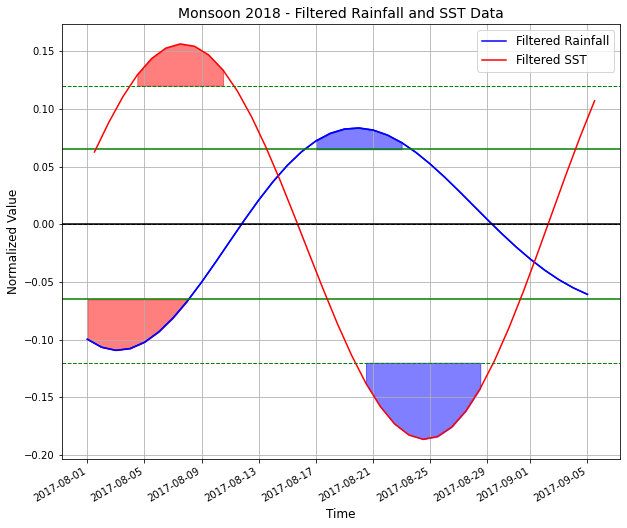

In [23]:
plt.figure(figsize=[10,8])

# Plot filtered rainfall data
rainfall_mean = Frf_mon.mean(dim = ['lon', 'lat'])[-276:-240]
filtered_rf = xr.DataArray(rainfall_mean, coords={"time":rainfall_mean.time},dims=["time"])
x = filtered_rf.time.data
y = filtered_rf.data
filtered_rf.plot(color = 'b', label='Filtered Rainfall')
sns.lineplot(x=x, y=y, color='b')
plt.axhline(y=0, color='black')
plt.axhline(y=0.065, color='g')
plt.axhline(y=-0.065, color='g')
above_threshold = y > 0.065
below_threshold = y < -0.065
plt.fill_between(x, y, 0.065, where=above_threshold, color='blue', alpha=0.5)
plt.fill_between(x, y, -0.065, where=below_threshold, color='red', alpha=0.5)


# Plot filtered SST data
sst_mean = Fsst_mon.mean(dim = ['lon', 'lat'])[-276:-240]
filtered_sst = xr.DataArray(sst_mean, coords={"time":sst_mean.time},dims=["time"])
x = filtered_sst.time.data
y = filtered_sst.data
filtered_sst.plot(color = 'r', label='Filtered SST')

# Add horizontal lines and fill color between them
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.axhline(y=0.120, color='g', linestyle='--', linewidth=1)
plt.axhline(y=-0.120, color='g', linestyle='--', linewidth=1)
above_threshold = y > 0.120
below_threshold = y < -0.120
plt.fill_between(x, y, 0.120, where=above_threshold, color='red', alpha=0.5)
plt.fill_between(x, y, -0.120, where=below_threshold, color='blue', alpha=0.5)

# Set axis labels and title
plt.xlabel('Time', fontsize=12)
plt.ylabel('Normalized Value', fontsize=12)
plt.title("Monsoon 2018 - Filtered Rainfall and SST Data", fontsize=14)

# Add legend
plt.legend(loc='upper right', fontsize=12)

# Add gridlines
plt.grid(True)

# Save figure
plt.savefig("CombinedSSTRF2017.png")


# Model Performance

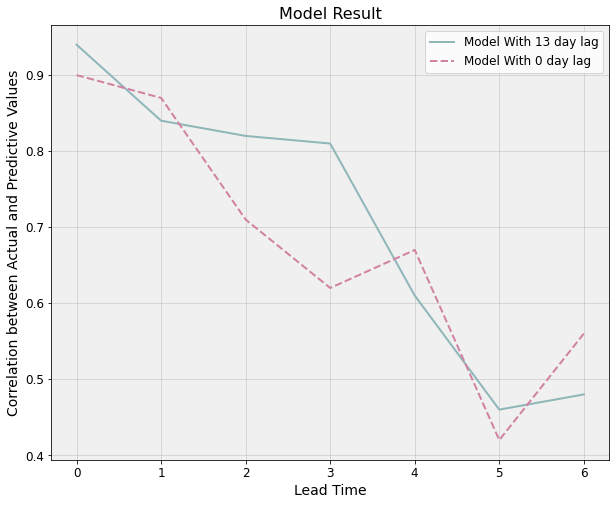

In [12]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = [10,8])
# Generate some data
x = np.arange(0, 7, 1)
y1 = [0.94, 0.84, 0.82, 0.81, 0.61, 0.46, 0.48]

y2 = [0.90, 0.87, 0.71, 0.62, 0.67, 0.42, 0.56]

# Plot the data
plt.plot(x, y1, color='#8fb6b8', linestyle='-', linewidth=2, label='Model With 13 day lag')
plt.plot(x, y2, color='#d182a2', linestyle='--', linewidth=2, label='Model With 0 day lag')

# Add a title, legend, and labels to the plot
plt.title('Model Result', fontsize=16)
plt.legend(fontsize=12, loc='upper right')
plt.xlabel('Lead Time', fontsize=14)
plt.ylabel('Correlation between Actual and Predictive Values', fontsize=14)

# Customize the axes ticks and grid lines
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.5)

# Add some annotations to the plot
#plt.text(4, 20, 'Line 1', fontsize=14, color='#8fb6b8')
#plt.text(2, 31, 'Line 2', fontsize=14, color='#d182a2')
#plt.annotate('Intersection', xy=(2.6, 8.8), xytext=(3.5, 13),arrowprops=dict(facecolor='black', shrink=0.05))

# Add a background color to the plot
ax = plt.gca()
ax.set_facecolor('#f0f0f0')

# Show the plot
plt.savefig("Model_Performance")
plt.show()

In [24]:

def preprocess_data(sequence, n_steps, channels):
    """
    Function to preprocess the data and prepare it for model training.
    
    Parameters:
        sequence (xarray.Dataset): Data sequence to be preprocessed.
        n_steps (int): Number of time steps in the input sequence.
        channels (int): Number of channels in the input sequence.
    
    Returns:
        tuple: A tuple containing the preprocessed input sequence (X) and output sequence (y).
    """
    # Select data for Jun, Jul, Aug, Sept
    sequence = sequence.sel(time=slice("2017-08-01","2017-08-15"))
    sequence = sequence.where(sequence.time.dt.month.isin([6,7,8,9]), drop=True)
    max = sequence.max()
    min = sequence.min()
    
    # Max-min normalization
    sequence = (sequence-min)/(max - min)
    sequence = np.array(sequence)
    
    # Exponential Space Transform
    valid_pts = np.where(sequence==sequence)
    sequence[valid_pts] = np.exp(sequence[valid_pts])
    sequence[valid_pts] = np.power(sequence[valid_pts],7)
    invalid_pts = np.where(sequence != sequence)
    sequence[invalid_pts] = 0
    
    # Prepare input and output sequences
    X, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix + lead_time > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix + lead_time]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


def create_input(channels, n_steps):
    """
    Function to create the input for the model.
    
    Parameters:
        channels (list): List of channels to be used in the input.
        n_steps (int): Number of time steps in the input sequence.
        
    Returns:
        numpy.ndarray: The input for the model.
    """
    stack = []
    for i in range(len(channels)):
        channel_data = xr.open_dataarray(f"/home/cccr/roxy/matin/MTech_project/data/{channels[i]}")
        input, _ = preprocess_data(channel_data, n_steps=n_steps, channels=channels[i])
        input = np.expand_dims(input, axis=2)
        print(f"Adding channel {i} with shape: {input.shape}")
        stack.append(input)
    out = np.dstack(stack)
    return out



In [30]:
lead_time = 0
channels = ["FilteredrfBOB_13lag.nc","FilteredSSTBOB_13.nc"]
steps = 7

# Create input for the model
input = create_input(channels, steps)

# Preprocess target data
channel_data = xr.open_dataarray(add_data + "FilteredrfBOB_13lag.nc")
_, target = preprocess_data(channel_data, n_steps=steps, channels=channels[-1])
target = np.expand_dims(target, axis=1)

# Roll axes for input and target
x = np.rollaxis(input, 4, 2)
x = np.rollaxis(x, 4, 2)

y = np.rollaxis(target, 3, 1)
y = np.rollaxis(y, 3, 1)

# Assert that input and target shapes are consistent
assert input.shape[0] == target.shape[0]
assert input.shape[-1] == target.shape[-1]
assert input.shape[-2] == target.shape[-2]


# Print shape of input and target
print("INPUT SHAPE --> ", input.shape)
print("TARGET SHAPE --> ", target.shape)

# Delete original input and target variables to free up memory
del input
del target


Adding channel 0 with shape: (8, 7, 1, 25, 39)
Adding channel 1 with shape: (8, 7, 1, 25, 39)
INPUT SHAPE -->  (8, 7, 2, 25, 39)
TARGET SHAPE -->  (8, 1, 25, 39)


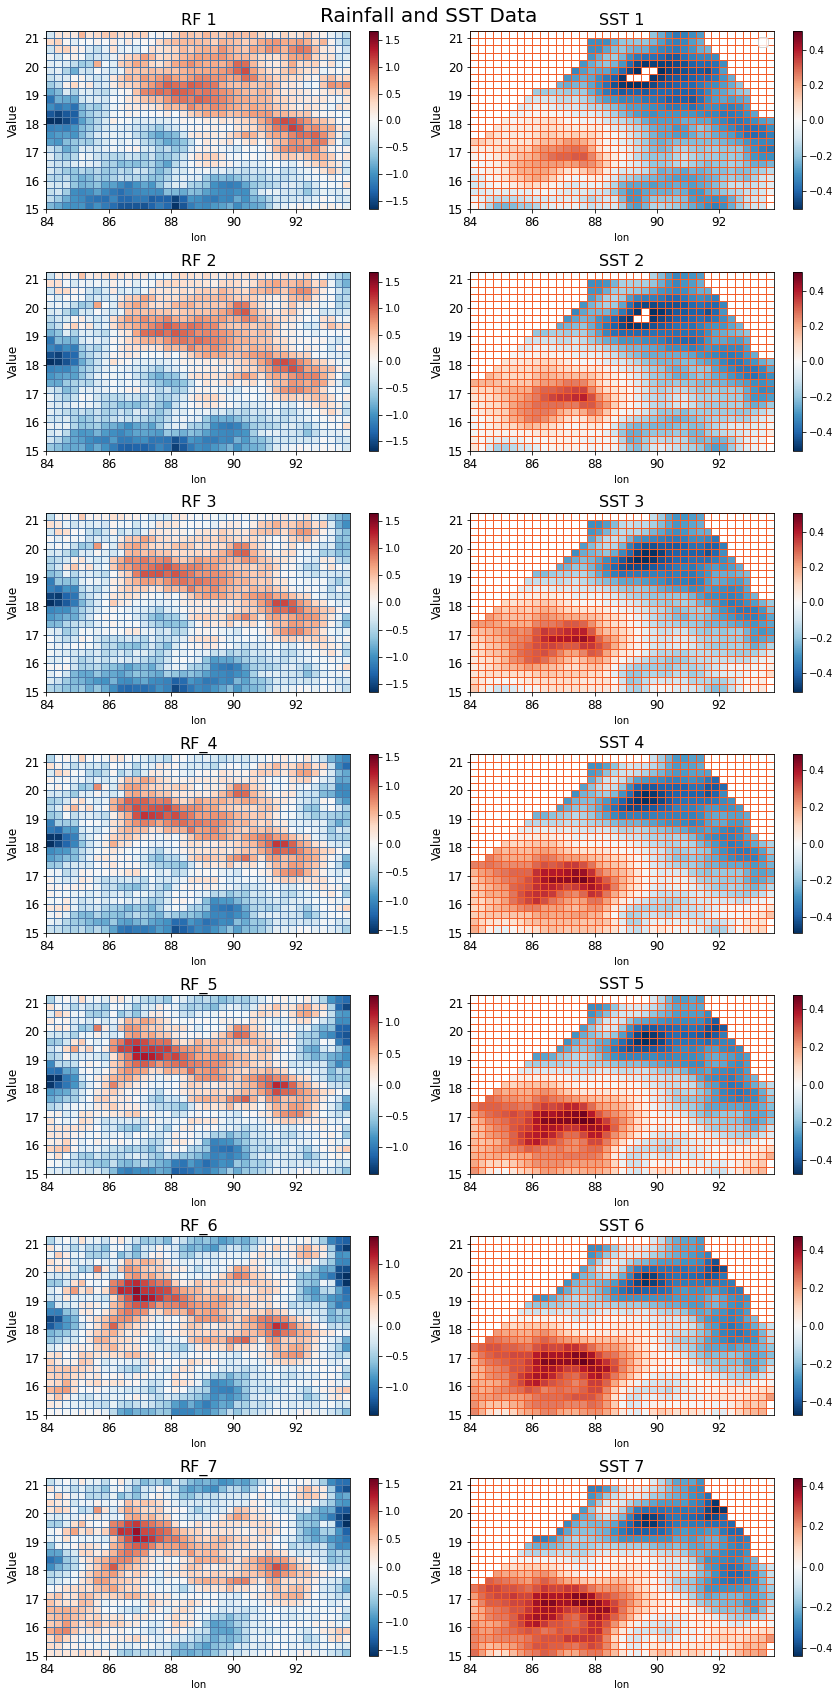

In [31]:
a = xr.open_dataarray(add_data+"FilteredrfBOB_13lag.nc") #[-518:-503]
sequence = a.sel(time=slice("2017-05-01","2017-09-15"))
max = sequence.max()
min = sequence.min()
    
Data_rf = xr.DataArray(x[0,:,:,:,0],
            dims=('time', 'lat', 'lon'),
            coords={'time': a.time[:7].data, 'lat': a.lat.data, 'lon': a.lon.data}
       )


sequence = Data_rf.values
valid_pts = np.where(sequence==sequence)
sequence[valid_pts] = np.power(sequence[valid_pts],1/7)
sequence[valid_pts] = np.log(sequence[valid_pts])
invalid_pts = np.where(sequence == 0)
sequence[invalid_pts] = np.nan

sequence = xr.DataArray(sequence,dims=('time', 'lat', 'lon'),coords={'time': a[:7].time.data,'lat': a.lat.data,'lon':a.lon.data})
Data_rf = sequence*(max - min)+min 
Data_rf = Data_rf.interpolate_na(dim="time")

b = xr.open_dataarray(add_data+"FilteredSSTBOB_13.nc") #[-518:-503]
sequence = b.sel(time=slice("2017-05-01","2017-09-15"))
max = sequence.max()
min = sequence.min()

Data_sst = xr.DataArray(x[0,:,:,:,1],
            dims=('time', 'lat', 'lon'),
            coords={'time': a.time[:7].data, 'lat': a.lat.data, 'lon': a.lon.data})

sequence = Data_sst.values
valid_pts = np.where(sequence==sequence)
sequence[valid_pts] = np.power(sequence[valid_pts],1/7)
sequence[valid_pts] = np.log(sequence[valid_pts])
invalid_pts = np.where(sequence == 0)
sequence[invalid_pts] = np.nan

sequence = xr.DataArray(sequence,dims=('time', 'lat', 'lon'),coords={'time': a[:7].time.data,'lat': a.lat.data,'lon':a.lon.data})
Data_sst = sequence*(max - min)+min 
Data_sst = Data_sst.interpolate_na(dim="time")


# Define variables for actual and predicted values
datasets = [(Data_rf[0],Data_sst[0], 'RF 1', 'SST 1'),
            (Data_rf[1],Data_sst[1], 'RF 2', 'SST 2'),
            (Data_rf[2],Data_sst[2], 'RF 3', 'SST 3'),
            (Data_rf[3],Data_sst[3], 'RF_4', 'SST 4'),
            (Data_rf[4],Data_sst[4], 'RF_5', 'SST 5'),
            (Data_rf[5],Data_sst[5], 'RF_6', 'SST 6'),
            (Data_rf[6],Data_sst[6], 'RF_7', 'SST 7')]

# Define a color palette for the actual and predicted data
palette = ['#4e79a7', '#f25e2b']

# Create subplots in a 7x2 layout
fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(12, 24))

# Add a common title to the entire plot
fig.suptitle('Rainfall and SST Data', fontsize=20)

# Iterate over the datasets and plot them in the subplots
for i, (actual, predicted, title_actual, title_predicted) in enumerate(datasets):
    actual.plot(ax=axs[i, 0], color=palette[0])
    axs[i, 0].set_title(title_actual, fontsize=16)
    axs[i, 0].set_ylabel('Value', fontsize=12)
    axs[i, 0].tick_params(axis='both', which='major', labelsize=12)
    predicted.plot(ax=axs[i, 1], color=palette[1])
    axs[i, 1].set_title(title_predicted, fontsize=16)
    axs[i, 1].set_ylabel('Value', fontsize=12)
    axs[i, 1].tick_params(axis='both', which='major', labelsize=12)

    # Add a legend to explain the colors of the actual and predicted data
    if i == 0:
        axs[i, 1].legend(['RainFall', 'SST'], fontsize=12, loc='upper right')

# Adjust the spacing between the subplots
plt.tight_layout()

# Display the plot
plt.savefig("Model_INPUT")
plt.show()


In [32]:
def In_Out(lead_time):
    channels = ["FilteredrfBOB_13lag.nc","FilteredSSTBOB_13.nc"]
    steps = 7

    # Create input for the model
    input = create_input(channels, steps)

    # Preprocess target data
    channel_data = xr.open_dataarray(add_data + "FilteredrfBOB_13lag.nc")
    _, target = preprocess_data(channel_data, n_steps=steps, channels=channels[-1])
    target = np.expand_dims(target, axis=1)

    # Roll axes for input and target
    x = np.rollaxis(input, 4, 2)
    x = np.rollaxis(x, 4, 2)

    y = np.rollaxis(target, 3, 1)
    y = np.rollaxis(y, 3, 1)

    # Assert that input and target shapes are consistent
    assert input.shape[0] == target.shape[0]
    assert input.shape[-1] == target.shape[-1]
    assert input.shape[-2] == target.shape[-2]


    # Print shape of input and target
    print("INPUT SHAPE --> ", input.shape)
    print("TARGET SHAPE --> ", target.shape)
  
    # Delete original input and target variables to free up memory
    del input
    del target
    return x,y


In [33]:
a = xr.open_dataarray(add_data+"FilteredrfBOB_13lag.nc") #[-518:-503]
sequence = a.sel(time=slice("2017-08-01","2017-08-15"))
max = sequence.max()
min = sequence.min()


# Max-min normalization
sequence = (sequence-min)/(max - min)


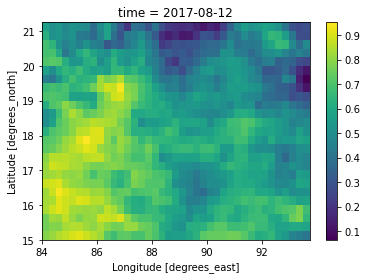

In [34]:
sequence[11].plot()

In [35]:
x,_ = In_Out(0)

model_path = save_path + "7in1out/ConvLstm_sst13rf_rf_0bob.h5"
model = tf.keras.models.load_model(model_path)
pred = model.predict(x)

a = xr.open_dataarray(add_data+"FilteredrfBOB_13lag.nc")
sequence = a.sel(time=slice("2017-08-01","2017-08-15"))
max = sequence.max()
min = sequence.min()
# Max-min normalization
y = (sequence-min)/(max - min)

Actual_d1 = y[7]
Actual_d2 = y[8]
Actual_d3 = y[9]
Actual_d4 = y[10]
Actual_d5 = y[11]
Actual_d6 = y[12]
Actual_d7 = y[13]

sequence = pred[0,:,:,0]
valid_pts = np.where(sequence==sequence)
sequence[valid_pts] = np.power(sequence[valid_pts],1/7)
sequence[valid_pts] = np.log(sequence[valid_pts])
invalid_pts = np.where(sequence == 0)
sequence[invalid_pts] = np.nan

sequence = xr.DataArray(sequence,dims=( 'lat', 'lon'),coords={'lat': a.lat.data,'lon':a.lon.data})
#sequence = sequence*(max - min)+min 
pred_d1 = sequence


x,_ = In_Out(1)

model_path = save_path + "7in2out/ConvLstm_sst13rf_rf_1bob.h5"
model = tf.keras.models.load_model(model_path)
pred = model.predict(x)

sequence = pred[0,:,:,0]
valid_pts = np.where(sequence==sequence)
sequence[valid_pts] = np.power(sequence[valid_pts],1/7)
sequence[valid_pts] = np.log(sequence[valid_pts])
invalid_pts = np.where(sequence == 0)
sequence[invalid_pts] = np.nan

sequence = xr.DataArray(sequence,dims=( 'lat', 'lon'),coords={'lat': a.lat.data,'lon':a.lon.data})
#sequence = sequence*(max - min)+min 
pred_d2 = sequence


x,_ = In_Out(2)

model_path = save_path + "7in3out/ConvLstm_sst13rf_rf_2bob.h5"
model = tf.keras.models.load_model(model_path)
pred = model.predict(x)

sequence = pred[0,:,:,0]
valid_pts = np.where(sequence==sequence)
sequence[valid_pts] = np.power(sequence[valid_pts],1/7)
sequence[valid_pts] = np.log(sequence[valid_pts])
invalid_pts = np.where(sequence == 0)
sequence[invalid_pts] = np.nan

sequence = xr.DataArray(sequence,dims=( 'lat', 'lon'),coords={'lat': a.lat.data,'lon':a.lon.data})
#sequence = sequence*(max - min)+min 
pred_d3 = sequence


x,_ = In_Out(3)

model_path = save_path + "7in4out/ConvLstm_sst13rf_rf_3bob.h5"
model = tf.keras.models.load_model(model_path)
pred = model.predict(x)


sequence = pred[0,:,:,0]
valid_pts = np.where(sequence==sequence)
sequence[valid_pts] = np.power(sequence[valid_pts],1/7)
sequence[valid_pts] = np.log(sequence[valid_pts])
invalid_pts = np.where(sequence == 0)
sequence[invalid_pts] = np.nan

sequence = xr.DataArray(sequence,dims=( 'lat', 'lon'),coords={'lat': a.lat.data,'lon':a.lon.data})
#sequence = sequence*(max - min)+min 
pred_d4 = sequence

x,_ = In_Out(4)

model_path = save_path + "7in5out/ConvLstm_sst13rf_rf_4bob.h5"
model = tf.keras.models.load_model(model_path)
pred = model.predict(x)


sequence = pred[0,:,:,0]
valid_pts = np.where(sequence==sequence)
sequence[valid_pts] = np.power(sequence[valid_pts],1/7)
sequence[valid_pts] = np.log(sequence[valid_pts])
invalid_pts = np.where(sequence == 0)
sequence[invalid_pts] = np.nan

sequence = xr.DataArray(sequence,dims=( 'lat', 'lon'),coords={'lat': a.lat.data,'lon':a.lon.data})
#sequence = sequence*(max - min)+min 
pred_d5 = sequence


x,_ = In_Out(5)

model_path = save_path + "7in6out/ConvLstm_sst13rf_rf_5bob.h5"
model = tf.keras.models.load_model(model_path)
pred = model.predict(x)


sequence = pred[0,:,:,0]
valid_pts = np.where(sequence==sequence)
sequence[valid_pts] = np.power(sequence[valid_pts],1/7)
sequence[valid_pts] = np.log(sequence[valid_pts])
invalid_pts = np.where(sequence == 0)
sequence[invalid_pts] = np.nan

sequence = xr.DataArray(sequence,dims=( 'lat', 'lon'),coords={'lat': a.lat.data,'lon':a.lon.data})
#sequence = sequence*(max - min)+min 
pred_d6 = sequence



x,_ = In_Out(6)

model_path = save_path + "7in7out/ConvLstm_sst13rf_rf_6bob.h5"
model = tf.keras.models.load_model(model_path)
pred = model.predict(x)


sequence = pred[0,:,:,0]
valid_pts = np.where(sequence==sequence)
sequence[valid_pts] = np.power(sequence[valid_pts],1/7)
sequence[valid_pts] = np.log(sequence[valid_pts])
invalid_pts = np.where(sequence == 0)
sequence[invalid_pts] = np.nan

sequence = xr.DataArray(sequence,dims=( 'lat', 'lon'),coords={'lat': a.lat.data,'lon':a.lon.data})
#sequence = sequence*(max - min)+min 
pred_d7 = sequence


Adding channel 0 with shape: (8, 7, 1, 25, 39)
Adding channel 1 with shape: (8, 7, 1, 25, 39)
INPUT SHAPE -->  (8, 7, 2, 25, 39)
TARGET SHAPE -->  (8, 1, 25, 39)


2023-03-19 18:10:51.532795: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


1/1 [==============================] - 5s 5s/step
Adding channel 0 with shape: (8, 7, 1, 25, 39)
Adding channel 1 with shape: (8, 7, 1, 25, 39)
INPUT SHAPE -->  (8, 7, 2, 25, 39)
TARGET SHAPE -->  (8, 1, 25, 39)
1/1 [==============================] - 1s 831ms/step
Adding channel 0 with shape: (8, 7, 1, 25, 39)
Adding channel 1 with shape: (8, 7, 1, 25, 39)
INPUT SHAPE -->  (8, 7, 2, 25, 39)
TARGET SHAPE -->  (8, 1, 25, 39)
1/1 [==============================] - 1s 815ms/step
Adding channel 0 with shape: (8, 7, 1, 25, 39)
Adding channel 1 with shape: (8, 7, 1, 25, 39)
INPUT SHAPE -->  (8, 7, 2, 25, 39)
TARGET SHAPE -->  (8, 1, 25, 39)
1/1 [==============================] - 1s 800ms/step
Adding channel 0 with shape: (8, 7, 1, 25, 39)
Adding channel 1 with shape: (8, 7, 1, 25, 39)
INPUT SHAPE -->  (8, 7, 2, 25, 39)
TARGET SHAPE -->  (8, 1, 25, 39)
1/1 [==============================] - 1s 804ms/step
Adding channel 0 with shape: (8, 7, 1, 25, 39)
Adding channel 1 with shape: (8, 7, 1, 25, 

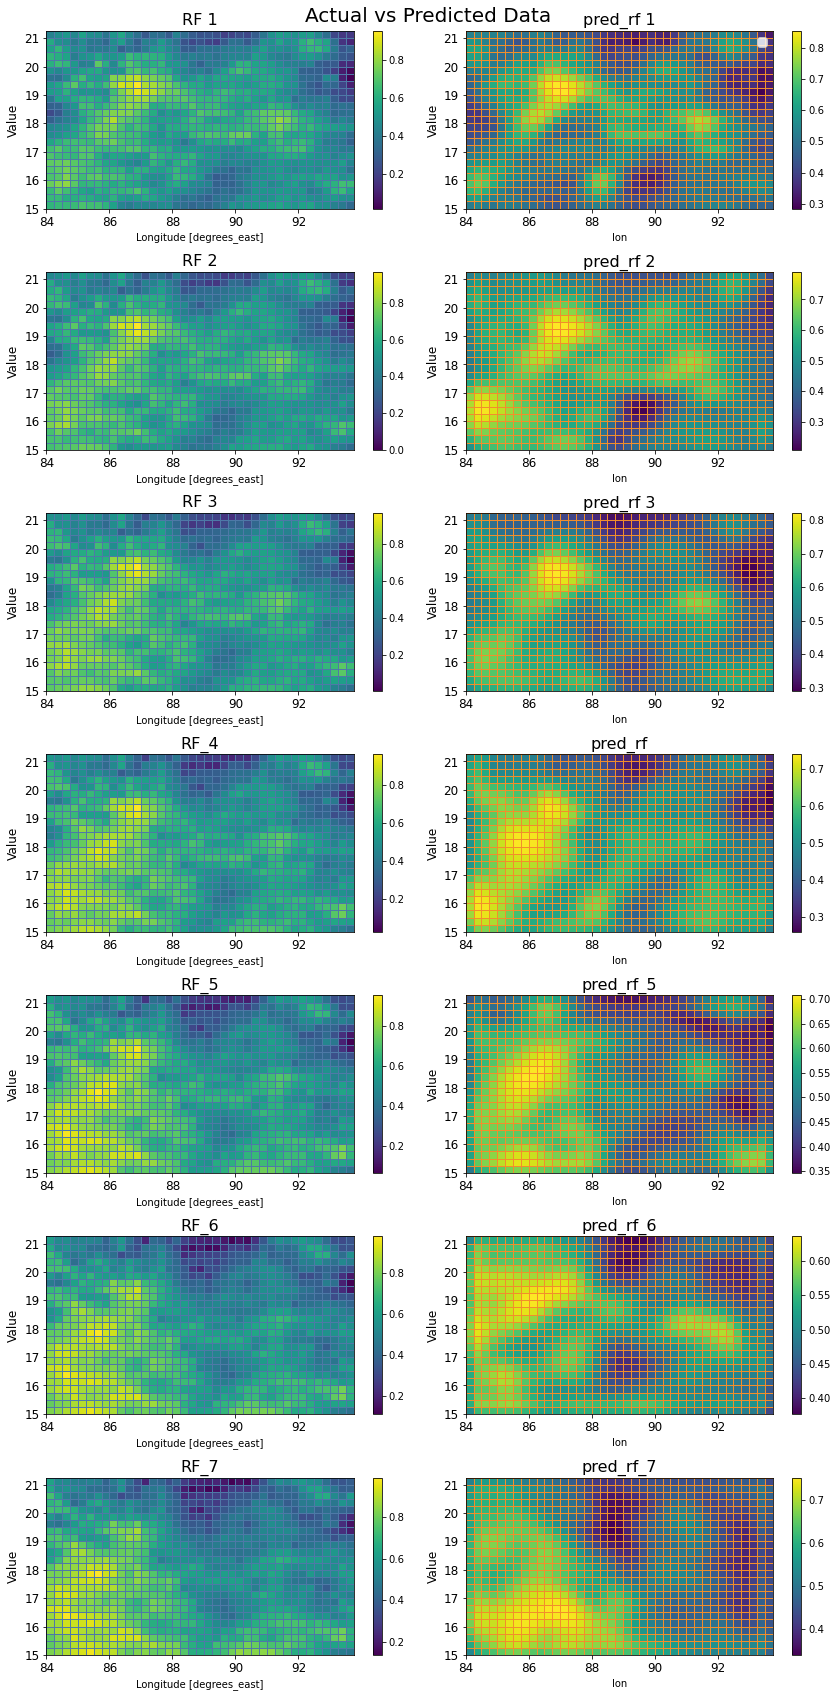

In [36]:
# Define variables for actual and predicted values
datasets = [(Actual_d1, pred_d1, 'RF 1', 'pred_rf 1'),
            (Actual_d2, pred_d2, 'RF 2', 'pred_rf 2'),
            (Actual_d3, pred_d3, 'RF 3', 'pred_rf 3'),
            (Actual_d4, pred_d4, 'RF_4', 'pred_rf'),
            (Actual_d5, pred_d5, 'RF_5', 'pred_rf_5'),
            (Actual_d6, pred_d6, 'RF_6', 'pred_rf_6'),
            (Actual_d7, pred_d7, 'RF_7', 'pred_rf_7')]

# Define a color palette for the actual and predicted data
palette = ['#4e79a7', '#f28e2b']

# Create subplots in a 7x2 layout
fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(12, 24))

# Add a common title to the entire plot
fig.suptitle('Actual vs Predicted Data', fontsize=20)

# Iterate over the datasets and plot them in the subplots
for i, (actual, predicted, title_actual, title_predicted) in enumerate(datasets):
    actual.plot(ax=axs[i, 0], color=palette[0])
    axs[i, 0].set_title(title_actual, fontsize=16)
    axs[i, 0].set_ylabel('Value', fontsize=12)
    axs[i, 0].tick_params(axis='both', which='major', labelsize=12)
    predicted.plot(ax=axs[i, 1], color=palette[1])
    axs[i, 1].set_title(title_predicted, fontsize=16)
    axs[i, 1].set_ylabel('Value', fontsize=12)
    axs[i, 1].tick_params(axis='both', which='major', labelsize=12)

    # Add a legend to explain the colors of the actual and predicted data
    if i == 0:
        axs[i, 1].legend(['Actual', 'Predicted'], fontsize=12, loc='upper right')

# Adjust the spacing between the subplots
plt.tight_layout()

plt.savefig("Model_Output")
plt.show()


In [37]:
data = xr.concat([pred_d1,pred_d2,pred_d3,pred_d4,pred_d5,pred_d6,pred_d7], dim='time').data
pred_seq = xr.Dataset({'data': (['time', 'lat', 'lon'], data)}, coords={'time':a[7:14].time.data,'lat':a.lat.data,'lon':a.lon.data})
pred_seq = pred_seq*(max - min)+min 

In [38]:
data_act = xr.concat([Actual_d1,Actual_d2,Actual_d3,Actual_d4,Actual_d5,Actual_d6,Actual_d7], dim='time').data
act_seq = xr.Dataset({'data': (['time', 'lat', 'lon'], data_act)}, coords={'time':a[7:14].time.data,'lat':a.lat.data,'lon':a.lon.data})
act_seq = act_seq*(max - min)+min 

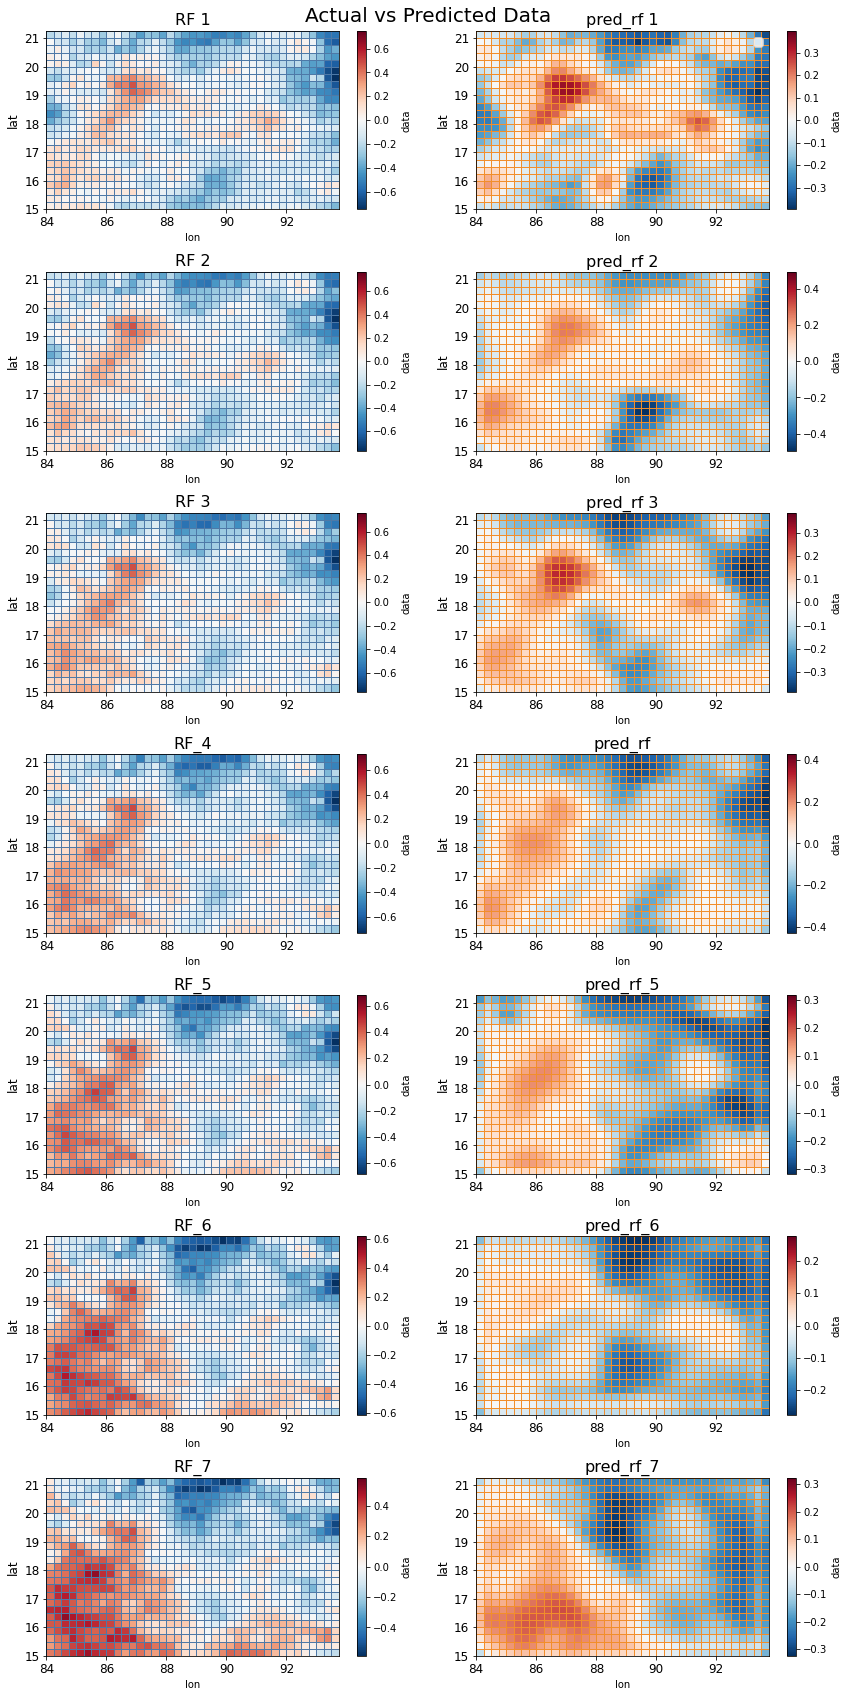

In [39]:

act_seq = act_seq.data
pred_seq = pred_seq.data

# Define variables for actual and predicted values
datasets = [(act_seq[0],pred_seq[0], 'RF 1', 'pred_rf 1'),
            (act_seq[1],pred_seq[1], 'RF 2', 'pred_rf 2'),
            (act_seq[2],pred_seq[2], 'RF 3', 'pred_rf 3'),
            (act_seq[3],pred_seq[3], 'RF_4', 'pred_rf'),
            (act_seq[4],pred_seq[4], 'RF_5', 'pred_rf_5'),
            (act_seq[5],pred_seq[5], 'RF_6', 'pred_rf_6'),
            (act_seq[6],pred_seq[6], 'RF_7', 'pred_rf_7')]

# Define a color palette for the actual and predicted data
palette = ['#4e79a7', '#f28e2b']

# Create subplots in a 7x2 layout
fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(12, 24))

# Add a common title to the entire plot
fig.suptitle('Actual vs Predicted Data', fontsize=20)

# Iterate over the datasets and plot them in the subplots
for i, (actual, predicted, title_actual, title_predicted) in enumerate(datasets):
    actual.plot(ax=axs[i, 0], color=palette[0])
    axs[i, 0].set_title(title_actual, fontsize=16)
    axs[i, 0].set_ylabel('lat', fontsize=12)
    axs[i, 0].tick_params(axis='both', which='major', labelsize=12)
    predicted.plot(ax=axs[i, 1], color=palette[1])
    axs[i, 1].set_title(title_predicted, fontsize=16)
    axs[i, 1].set_ylabel('lat', fontsize=12)
    axs[i, 1].tick_params(axis='both', which='major', labelsize=12)

    # Add a legend to explain the colors of the actual and predicted data
    if i == 0:
        axs[i, 1].legend(['Actual', 'Predicted'], fontsize=12, loc='upper right')

# Adjust the spacing between the subplots
plt.tight_layout()

# Display the plot
plt.savefig("Model_Output")
plt.show()

